Cameron Wood <br>
DTSA 5511 Final Project

GitHub Repo: https://github.com/cameronwood7/EMNIST-Unsupervised.git

### **Project Rundown**

The EMNIST (Extended Modified National Institute of Standards and Technology) Letters Dataset is an extension of the well-known MNIST dataset, which is the bread and butter of machine learning benchmarking. What sets EMNIST apart is its larger size and, as the name suggests, its inclusion of handwritten letters. This project will focus on the letter component within this extended dataset. </br>

Image processing often relies on deep learning, which can be CPU and GPU intensive. In this project, we will create some very basic Deep Learning methods, along with some Supervised Learning, to create a classification model for handwritten letters. These models will be efficient and can be used on everyday machines, which would make them more accessible and useful for a broader audience. 

### **Data Description**

The EMNIST Dataset was derived from the NIST Special Database 19 and converted to the same format and structure as the MNIST dataset. The original NIST Special Database 19 was currated from 3600 writers, consists of 810,000 character images and their respective true labels. </br>

More details about the collection and conversion process is described in *EMNIST: an extension of MNIST to handwritten letters* by Gregory Cohen, et al. The data itself can be found within the paper referenced. </br>

In the EMNIST Letters dataset, there are 88,800 samples in 26 classes representing every letter in the alphabet, upper- and lower-case. The data is stored in a binary format that describes the image in terms of 8-bit gray-scale resolution. All images are 28x28 pixels in size. </br>

#### References: </br>
Cohen, G., Afshar, S., Tapson, J., & van Schaik, A. (2017). EMNIST: an extension of MNIST to handwritten letters. Retrieved from http://arxiv.org/abs/1702.05373 </br>


### **Data Cleaning**

First we can run the cell below to get all of the necessary packages.

In [43]:
# Importing Packages

import math
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

# Importing all necessary libraries

import itertools
from math import exp
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM

import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy.stats import uniform

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

And then we can load in the data and check out what we're working with. We'll want to take note that the test dataset does not contain all of the letters in the alphabet, so we will just be using the training dataset and splitting it.

In [176]:
# Loading in the Dataset
data = pd.read_csv('emnist-letters-train.csv')

In [177]:
# Showing Data header
data.head()

,23,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.406,0.407,0.408,0.409,0.410,0.411,0.412,0.413,0.414,0.415
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,16,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,17,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


It looks like our column header for our 'labels' is named '23' in the data, so we can fix that for data set. This will make it easier to reference later on in the code. </b>

We also notice that the labels are listed as integers 1-26 representing the entire alphabet. We will maintain this labeling method for ease of use.

In [178]:
#Renaming Labels Column
data = data.rename({'23':'labels'}, axis='columns')

data = data[:40000]

# We'll also want to rename all the pixel columns to be representative of that

count = 0

for i in data.columns:
    if (i != 'labels'):
        newName = 'pixel' + str(count)
        data = data.rename({i:newName}, axis='columns')
        count += 1

In [179]:
#Checking the training data
data.head()

,labels,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,16,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,17,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now we'll want to check for any null values, and to make sure that the data types align with what we're expecting. This is so our models don't break down the line.

In [180]:
# Checking for Null Values
NullVal = data.isnull().sum()
print("For Train Data: ")
print(NullVal[NullVal != 0])

For Train Data: 
Series([], dtype: int64)


In [181]:
# Checking Data Types for the Data
print("Train Data: ")
print(data.info())

Train Data: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Columns: 785 entries, labels to pixel783
dtypes: int64(785)
memory usage: 239.6 MB
None


Lastly, we'll want to ensure that our pixel values contain intensity values, and that our training data has all 26 letters in it.

        pixel0   pixel1   pixel2        pixel3        pixel4        pixel5  \
count  40000.0  40000.0  40000.0  40000.000000  40000.000000  40000.000000   
mean       0.0      0.0      0.0      0.000025      0.003975      0.015425   
std        0.0      0.0      0.0      0.005000      0.512851      1.593095   
min        0.0      0.0      0.0      0.000000      0.000000      0.000000   
25%        0.0      0.0      0.0      0.000000      0.000000      0.000000   
50%        0.0      0.0      0.0      0.000000      0.000000      0.000000   
75%        0.0      0.0      0.0      0.000000      0.000000      0.000000   
max        0.0      0.0      0.0      1.000000     92.000000    192.000000   

             pixel6        pixel7        pixel8        pixel9  ...  pixel774  \
count  40000.000000  40000.000000  40000.000000  40000.000000  ...   40000.0   
mean       0.021800      0.021275      0.015425      0.007525  ...       0.0   
std        1.940417      2.013088      1.621405      0.96

Text(0.5, 1.0, 'Histogram of EMNIST Data Set')

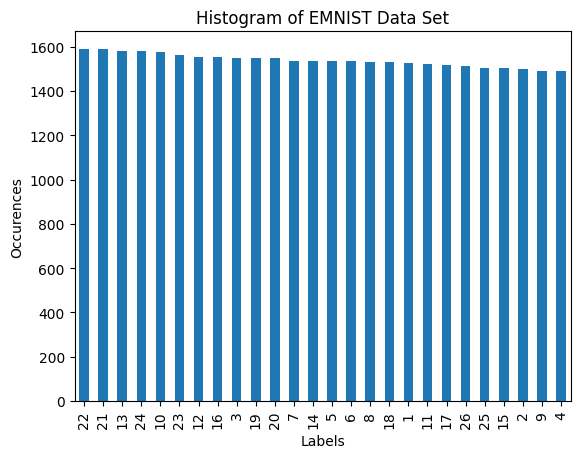

In [182]:
# For the training data
print(data.iloc[:, 1:].describe())

# Add Labels
ax = data['labels'].value_counts().plot(kind='bar')
ax.set_xlabel('Labels')
ax.set_ylabel('Occurences')
ax.set_title('Histogram of EMNIST Data Set')

Now that we have common column headers across both our dataset, we can now begin to work with the data in a meaningful way. EMNIST is a newer and less used dataset compared to MNIST, so it isn't as clean. We also confirmed that there are no null values within the dataset, and it consists of all integer values so we won't have any issues building our classification models. </br>

We also ensured that for the training and testing data sets have real intensity values in their pixels. We also ensured that there is an even distribution of letters within the data set, meaning we shouldn't have any bias towards a particular letter being trained on more significantly than any others. </br>

### **Exploratory Data Analysis**

Starting off we can split up our dataset into X, being our intensity values per pixel, and y, our labels. We'll also want to create an "alphabet" array to reference when accessing our labels.

In [183]:
# Seperating data from lables
X = data.drop('labels', axis=1).values
y = data['labels'].values

In [184]:
# Creating array of the alphabet
alphabet = []
for i in range(26):
    letter = chr(ord('a') + i)
    alphabet.append(letter)

Now we can use these new arrays to try plotting an example of what these handwritten letters look like. The images are flipped and rotated, so this is corrected in plotting. This fact won't change the classification models, since they are all in the same orientation.

In [135]:
# Method to view the letters at a specified index
def view_letter(data, label=None):
    fig = plt.figure(figsize=(3,3))
    data = np.flipud(data.reshape(28,28))
    data = np.rot90(data)
    data = np.rot90(data)
    data = np.rot90(data)
    plt.imshow(data, cmap='gray');
    plt.xticks([]); plt.yticks([]);
    if label: plt.xlabel("True: {}".format(label), fontsize=16) 

In the cell below we can play with the index value and show a letter with it's true label.

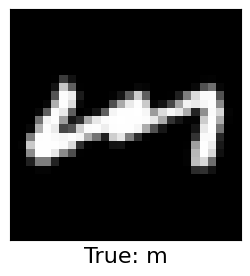

In [136]:
# Specify an index within the dataset and plot, along with specifying its true label
index = 5

view_letter(X[index], label=alphabet[y[index]-1])

Aside from the histogram showing the frequency of letters that show up in the dataset, found in the Data Cleaning section, we can also plot the intensities found across the dataset per letter.

Text(0.5, 1.0, 'Average Intensity Across EMNIST Dataset')

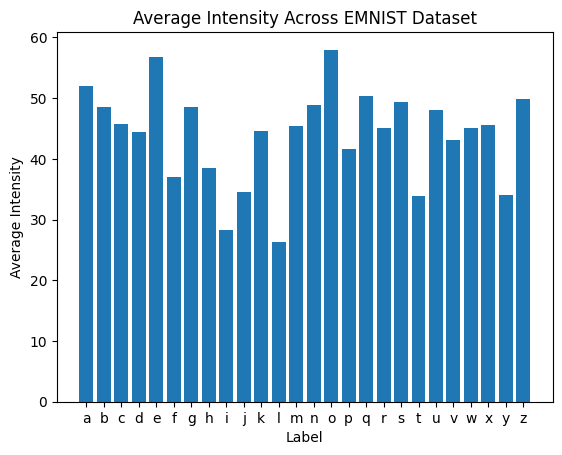

In [185]:
# Initialize arrays to store intensity values and counts
avg_intensity = np.zeros(26)
counts = np.zeros(26)

# Loop through X and gather information. Exlude intensity values of 0 which are black pixels

for i in range(len(X)):
    counts[y[i]-1] += 1
    avg_intensity[y[i]-1] += np.mean(X[i])

avg_intensity /= counts

# Plot a histogram of the intensity values

plt.bar(alphabet, avg_intensity)
plt.xlabel('Label')
plt.ylabel('Average Intensity')
plt.title('Average Intensity Across EMNIST Dataset')


We can see that there is quite a bit of variability in intensity between letters, but that is generally due to the size and shape of the letter written. For example, the letter i takes up significantly less space than something like a so the intensity is lower due to there being many more black pixels. </br>

Something else we can look at is the distribution of intensities across a particular letter. For this example I'll use the letter 'z' and compare it to 'o'.

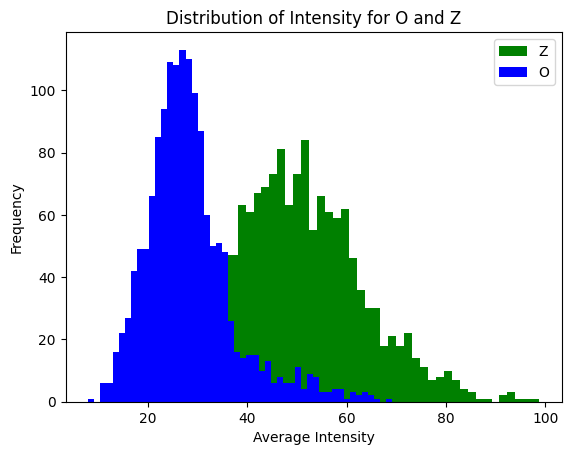

In [186]:
# Initialize Arrays
avg_intensity_z = []
avg_intensity_o = []

# Loop through the length and X and pick out any intensities that are Z or O
for i in range(len(X)):
    if y[i] == 26:
        avg_intensity_z.append(np.mean(X[i]))

    if y[i] == 9:
        avg_intensity_o.append(np.mean(X[i]))

# Plot the distribution of intensities                         
plt.hist(avg_intensity_z, bins=50, color='green', label='Z')
plt.hist(avg_intensity_o, bins=50, color='blue', label='O')
plt.xlabel('Average Intensity')
plt.ylabel('Frequency')
plt.title('Distribution of Intensity for O and Z')
plt.legend()

As one might expect, there is higher variability in how someone might write the z versus how someone might write the letter o. The purpose of showing these distributions also helps to show feature seperability, which will allow us to better classify the letters.

In conclusion, we have found that our dataset contains proper distribution of letters so we don't introduce any training bias towards any particular letter. We were also able to take a look at what the images look like, along with the distribution of their features (intensity values). </br>

As expected, smaller and small letters, like i and l will have lower intensity values than larger letters like o and z. We were also able to compare the distribution of intensities for the letters o and z to show variability. A simple letter like o has less variation in how people write it, versus something like z. Depending on the models you are interested in using, this feature seperability can help in classification. It's also important to note that these distributions follow a mostly normal distribution, meaning that the data set is truly random with differing variability. </br>

As we move onto our models, there are forseen challenges with respect to this dataset. For some letters, as mentioned in the Project Rundown, we see both upper- and lower-case letters. This will increase variability, and make it harder for our basic classifiers to find common features between the two.

### **Models**

To start off, we'll split our data into training and testing sets. For our purposes we'll use a test size of 20%. </br>

It should be noted that due to the random nature of our letters chosen, and all images independent of one another, there is no collinearity between the data and this will not be an issue with the following models.

In [187]:
# Split the data into train and test sets with a test size of 20%
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)

In [188]:
# Normalize pixel values for CNN
X_train_CNN, X_test_CNN = X_train / 255.0, X_test / 255.0
X_train_CNN, X_test_CNN = X_train_CNN.reshape((-1, 28, 28, 1)), X_test_CNN.reshape((-1, 28, 28, 1))

# Using to_categorical changes the labels to arrays of size 26, with a 1 in the index of the true letter, 
# allowing for probabilities for all other letters
y_train_CNN, y_test_CNN = to_categorical(y_train), to_categorical(y_test)

#### **Convolutional Neural Networks**

Convolutional Neural Networks (CNN) are a class of deep learning models specifically designed for processing structured grid data, such as images. They are composed of convolutional layers, activation functions, pooling layers, and fully connected layers. </br>

The advantage of using CNNs for EMNIST are multiple. They are great at extracting relevant features without the need for manual feature engineering which is very useful for classifying handwritten letteres with large variations. It can also pick up on local features like loops and lines you might find in letters like q and g. 

We will compare the performance between a more basic model consisting of 5 layers in all, and a second model which introduces dropout to try and reduce overfitting in our models.

In [141]:
def getBaseCNN():
    # Initialize a Sequential Model
    model = models.Sequential()

    # Convolutional layer with 32 filters, and a 3x3 kernal.
    # Followed by 2x2 pool to downsample features
    model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)))
    model.add(layers.MaxPooling2D((2, 2)))

    # Convolutional layer with 64 filters, and a 3x3 kernal.
    # Followed by 2x2 pool to downsample features
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Convolutional layer with 64 filters, and a 3x3 kernal.
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))

    # Flatten the 3D features into a 1D vector for fully connected layer
    model.add(layers.Flatten())

    # Fully connected layer with 128 neurons, connecting the features extracted above
    model.add(layers.Dense(128, activation='relu'))

    # 26 neurons to match the number of letters, along with probabilities for each using softmax
    model.add(layers.Dense(y_train_CNN.shape[1], activation='softmax'))

    return model

def getDropoutCNN():
    # Initialize a Sequential Model
    model = models.Sequential()

    # Convolutional layer with 32 filters, and a 3x3 kernal.
    # Followed by 2x2 pool to downsample features
    # Followed by a dropout layer of 20% to rid the model of over-fitting
    model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))

    # Convolutional layer with 64 filters, and a 3x3 kernal.
    # Followed by 2x2 pool to downsample features
    # Followed by a dropout layer of 20% to rid the model of over-fitting
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))

    # Convolutional layer with 64 filters, and a 3x3 kernal.
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))

    # Flatten the 3D features into a 1D vector for fully connected layer
    model.add(layers.Flatten())

    # Fully connected layer with 128 neurons, connecting the features extracted above
    # Follwoed by another dropout layer of 50%
    model.add(layers.Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    
    # 26 neurons to match the number of letters, along with probabilities for each using softmax
    model.add(layers.Dense(y_train_CNN.shape[1], activation='softmax'))

    return model

In [208]:
baseCNNModel = getCNN()
baseCNNModel.compile(optimizer='adam', #Adam allows for adaptive learning rates, and is pretty standard
                    loss='categorical_crossentropy', # This method is specifically designed for multi-class classification
                    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

print("Base CNN Model Summary:")
print(baseCNNModel.summary())

dropoutCNNModel = getCNN()
dropoutCNNModel.compile(optimizer='adam', 
                        loss='categorical_crossentropy', 
                        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

print("Dropout CNN Model Summary:")
print(dropoutCNNModel.summary())

Base CNN Model Summary:


Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_63 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_21 (Flatten)            │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 27)             │         3,483 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,083 (519.86 KB)

 Trainable params: 133,083 (519.86 KB)

 Non-trainable params: 0 (0.00 B)

None
Dropout CNN Model Summary:


Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_66 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_67 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_45 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_68 (Conv2D)              │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_22 (Flatten)            │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 27)             │         3,483 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,083 (519.86 KB)

 Trainable params: 133,083 (519.86 KB)

 Non-trainable params: 0 (0.00 B)

None


In [190]:
# Set up early stopping to mitigate increasing loss, and from running the model for longer than needed
# This checks if we are still decreasing our validation loss for 3 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

print("Training CNN Base Model")
baseCNNHist = baseCNNModel.fit(X_train_CNN, y_train_CNN, 
                                epochs=50, batch_size=64, # Set to high epoch, and also 64 images for balanced training size
                                validation_data=(X_test_CNN, y_test_CNN),
                                callbacks=[early_stopping])

print("Training CNN Dropout Model")      
dropCNNHist = dropoutCNNModel.fit(X_train_CNN, y_train_CNN, 
                                epochs=50, batch_size=64, 
                                validation_data=(X_test_CNN, y_test_CNN),
                                callbacks=[early_stopping])

Training CNN Base Model
Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5623 - loss: 1.5119 - precision_27: 0.7671 - recall_27: 0.4228 - val_accuracy: 0.8589 - val_loss: 0.4544 - val_precision_27: 0.8966 - val_recall_27: 0.8257
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8753 - loss: 0.3874 - precision_27: 0.9031 - recall_27: 0.8499 - val_accuracy: 0.8924 - val_loss: 0.3315 - val_precision_27: 0.9117 - val_recall_27: 0.8746
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9094 - loss: 0.2740 - precision_27: 0.9263 - recall_27: 0.8926 - val_accuracy: 0.8913 - val_loss: 0.3338 - val_precision_27: 0.9134 - val_recall_27: 0.8758
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9202 - loss: 0.2302 - precision_27: 0.9335 - recall_27: 0.9074 - val_accuracy: 0.9121 - val_loss: 0.2557 - val_precision_27: 0.9260 - val_recall_27: 0.9046
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9293 - loss: 0.19

#### **Recurrent Neural Networks / Long Short Term Memory Networks**

Long Short-Term Memory Networks are a specialized type of Recurrent Neural Network designed to effectively learn from sequences of data. LSTMs maintain a cell state that carries information throughout the sequence, utilize an input gate, forget gate, and output gate, and use activation functions.

Typically LSTMs are used for sequential data like time series or NLP, but they can also be useful for tasks like EMNIST where letters are formed in sequential order. LSTMs can effectively model how quickly a letter is written along with different styles, and can help differentiate between similar letters like g and q. 

In [191]:
# Reshape the training and test data to be in form (batch size, time steps, and features)
X_train_RNN = X_train_CNN.reshape((-1, 28, 28))
X_test_RNN = X_test_CNN.reshape((-1, 28, 28))

In [145]:
def getRNN():
    # Initialize as a Sequential model
    model = models.Sequential()

    # Add LSTM layer with 128 units, with an input shape of 28x28. 
    model.add(layers.LSTM(128, input_shape=(28, 28), return_sequences=False))

    # Add a fully connected layer with 128 neurons
    model.add(layers.Dense(128, activation='relu'))

    # Use softmax as the output for all class probabilities
    model.add(layers.Dense(y_train_CNN.shape[1], activation='softmax'))
    
    return model

In [192]:
# Grab a generic model and compile using parameters described above
RNNModel = getRNN()
RNNModel.compile(optimizer='adam', 
                loss='categorical_crossentropy', 
                metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
RNNModel.summary()

Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_19 (LSTM)                  │ (None, 128)            │        80,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 27)             │         3,483 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,379 (392.11 KB)

 Trainable params: 100,379 (392.11 KB)

 Non-trainable params: 0 (0.00 B)

In [193]:
# Fit using the train and test data, again using early stopping
RNNHist = RNNModel.fit(X_train_RNN, y_train_CNN, 
                        epochs=50, batch_size=64, 
                        validation_data=(X_test_RNN, y_test_CNN),
                        callbacks=[early_stopping])

Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.4220 - loss: 1.9526 - precision_29: 0.7305 - recall_29: 0.2344 - val_accuracy: 0.7879 - val_loss: 0.6841 - val_precision_29: 0.8501 - val_recall_29: 0.7303
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.8034 - loss: 0.6219 - precision_29: 0.8590 - recall_29: 0.7544 - val_accuracy: 0.8384 - val_loss: 0.5142 - val_precision_29: 0.8809 - val_recall_29: 0.8034
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.8535 - loss: 0.4512 - precision_29: 0.8861 - recall_29: 0.8266 - val_accuracy: 0.8679 - val_loss: 0.4178 - val_precision_29: 0.8963 - val_recall_29: 0.8415


##### **KNN**

K-Nearest Neighbors Classifiers are a great supervised learning model to use that is basic while also providing easily interpretable results. This will be good to test against the unsupervised clustering performance.

In [194]:
params = {
    'n_neighbors': [1, 2, 3, 4, 5], # Lower k-values typically do better, and saves on compute
    'weights': ['uniform', 'distance'], # We want to test whether weighting our neighbors helps performance
    'metric': ['euclidean'], # We'll maintain euclidean distance throughout
    'leaf_size': [5, 10, 15] # We'll manipulate our leaf size
}

# Now we can set up our Grid Search and train our model
KNN = GridSearchCV(KNeighborsClassifier(), params, cv=5, scoring='accuracy')

KNN.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': [5, 10, 15], 'metric': ['euclidean'],
                         'n_neighbors': [1, 2, 3, 4, 5],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [195]:
# Save off our best KNN Model
KNN_Best = KNN.best_estimator_

# And the best parameters are

print(KNN.best_params_)

{'leaf_size': 5, 'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}


### **Results and Analysis**

Now that we have multiple models, we can begin to compare the performance through multiple lenses. To guide this discussion, we can start off with Confusion Matricies for the different Neural Networks and KNN models.

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


Text(0.5, 1.0, 'KNN Confusion Matrix')

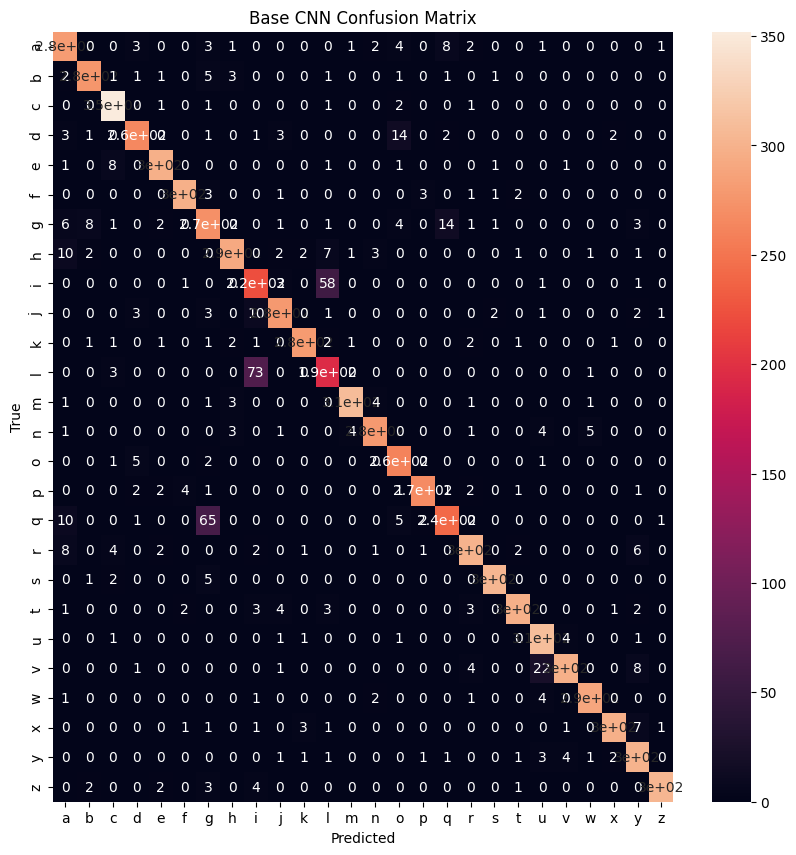

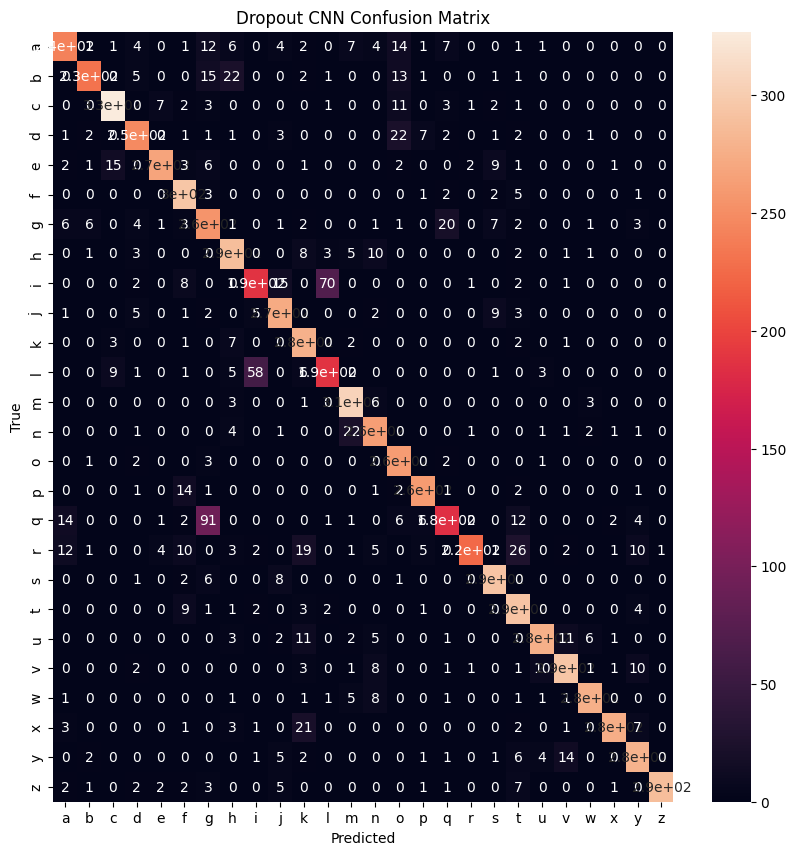

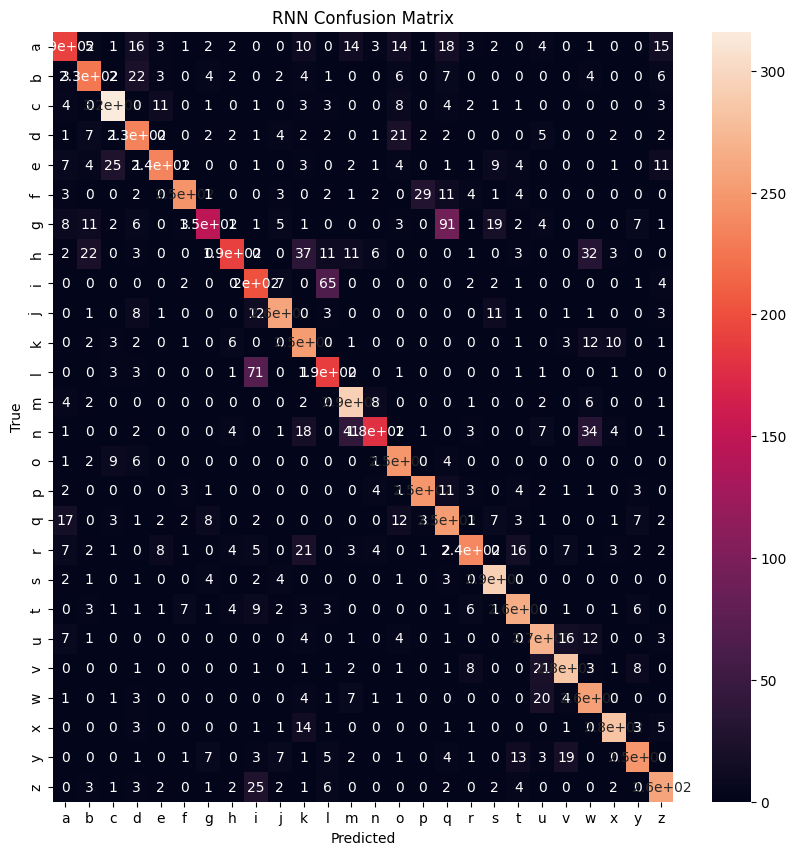

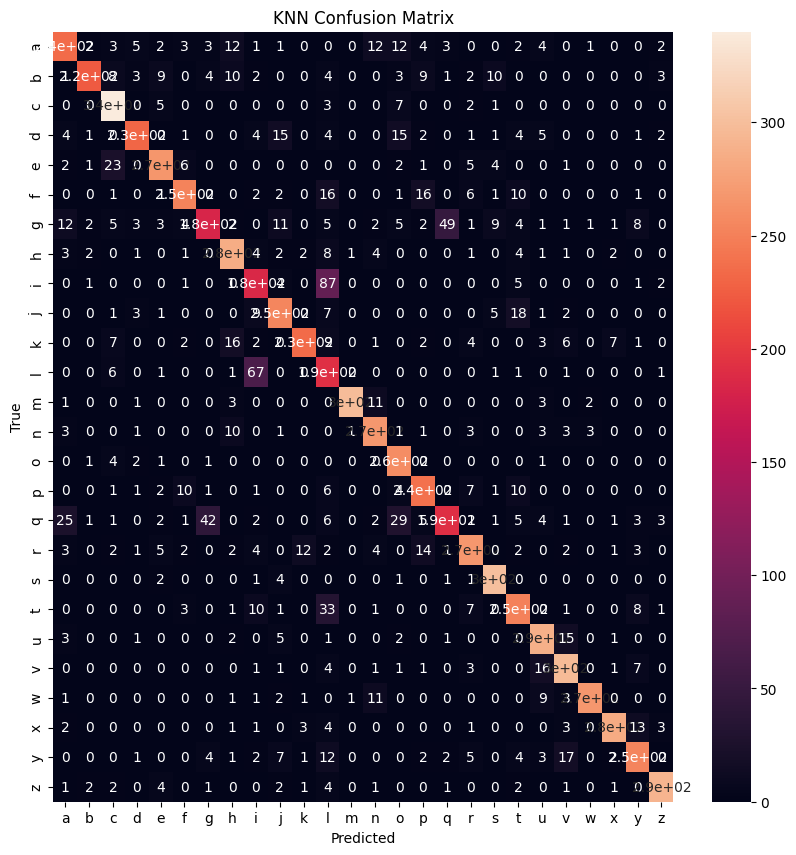

In [196]:
# First we can calculate the predictions
pred_CNN_base = baseCNNModel.predict(X_test_CNN)
pred_CNN_dropout = dropoutCNNModel.predict(X_test_CNN)
pred_RNN = RNNModel.predict(X_test_RNN)
pred_KNN = KNN_Best.predict(X_test)

# Further process the Neural Network predictions from probabilities to most likely class
y_test_classes = np.argmax(y_test_CNN, axis=1)
baseClasses = np.argmax(pred_CNN_base, axis=1)
dropoutClasses = np.argmax(pred_CNN_dropout, axis=1)
rnnClasses = np.argmax(pred_RNN, axis=1)

# Create the confusion matricies
cmCNNBase = confusion_matrix(y_test_classes, baseClasses)
cmCNNDropout = confusion_matrix(y_test_classes, dropoutClasses)
cmRNN = confusion_matrix(y_test_classes, rnnClasses)
cmKNN = confusion_matrix(y_test, pred_KNN)


# Plot the matricies as heat maps

# Base CNN
ax1 = plt
ax1.figure(figsize=(10,10))
sns.heatmap(cmCNNBase, annot=True, xticklabels=alphabet, yticklabels=alphabet)
ax1.xlabel('Predicted')
ax1.ylabel('True')
ax1.title('Base CNN Confusion Matrix')

# Dropout CNN
ax2 = plt
ax2.figure(figsize=(10,10))
sns.heatmap(cmCNNDropout, annot=True, xticklabels=alphabet, yticklabels=alphabet)
ax2.xlabel('Predicted')
ax2.ylabel('True')
ax2.title('Dropout CNN Confusion Matrix')

# RNN
ax3 = plt
ax3.figure(figsize=(10,10))
sns.heatmap(cmRNN, annot=True, xticklabels=alphabet, yticklabels=alphabet)
ax3.xlabel('Predicted')
ax3.ylabel('True')
ax3.title('RNN Confusion Matrix')

# KNN
ax4 = plt
ax4.figure(figsize=(10,10))
sns.heatmap(cmKNN, annot=True, xticklabels=alphabet, yticklabels=alphabet)
ax4.xlabel('Predicted')
ax4.ylabel('True')
ax4.title('KNN Confusion Matrix')

As one may have expected, we see misclassifications in letters that look similar in all models: i, t and l, c and e. In all of their lower-case forms, they all follow a similar geometry when it comes to writing making it difficult for classifiers like these to distinguish them 100% of the time. </br>

As mentioned above, however, the LSTM model (labeled RNN) excels in differentiating between these similar looking letters almost never failing on letters like g and q, t and l or similar that the CNNs and KNN model get tripped up on. 

To get more granular, we will now look at the accuracy, precision, and recall for these models. Since this is a classification problem, we'll want to know how often we predicted correctly, how often our positive predictions were correct, and our models' abilities to correctly identify positive instances.

In [197]:
# Calculate Metrics for CNN Base
prec_CNN_base = precision_score(y_test_classes, baseClasses, average=None)
rec_CNN_base = recall_score(y_test_classes, baseClasses, average=None)
acc_CNN_base = accuracy_score(y_test_classes, baseClasses)

# Calculate Metrics for CNN Droupout
prec_CNN_drop = precision_score(y_test_classes, dropoutClasses, average=None)
rec_CNN_drop = recall_score(y_test_classes, dropoutClasses, average=None)
acc_CNN_drop = accuracy_score(y_test_classes, dropoutClasses)

# Calculate Metrics for RNN Dropout
prec_RNN = precision_score(y_test_classes, rnnClasses, average=None)
rec_RNN = recall_score(y_test_classes, rnnClasses, average=None)
acc_RNN = accuracy_score(y_test_classes, rnnClasses)

# Calculate Metrics for KNN_Best

prec_KNN = precision_score(y_test, pred_KNN, average=None)
rec_KNN = recall_score(y_test, pred_KNN, average=None)
acc_KNN = accuracy_score(y_test, pred_KNN)

# Print out Stats

print(" ")
print("CNN Base Model Stats: ")
print("Accuracy: ")
print(acc_CNN_base)
print("Precision: ")
print(np.mean(prec_CNN_base))
print("Recall: ")
print(np.mean(rec_CNN_base))

print(" ")
print("CNN Dropout Model Stats: ")
print("Accuracy: ")
print(acc_CNN_drop)
print("Precision: ")
print(np.mean(prec_CNN_drop))
print("Recall: ")
print(np.mean(rec_CNN_drop))

print(" ")
print("RNN Model Stats: ")
print("Accuracy: ")
print(acc_RNN)
print("Precision: ")
print(np.mean(prec_RNN))
print("Recall: ")
print(np.mean(rec_RNN))

print(" ")
print("KNN Model Stats: ")
print("Accuracy: ")
print(acc_KNN)
print("Precision: ")
print(np.mean(prec_KNN))
print("Recall: ")
print(np.mean(rec_KNN))

 
CNN Base Model Stats: 
Accuracy: 
0.92
Precision: 
0.9212844184699102
Recall: 
0.9189852809931386
 
CNN Dropout Model Stats: 
Accuracy: 
0.8565
Precision: 
0.8612819959641337
Recall: 
0.8562391133961781
 
RNN Model Stats: 
Accuracy: 
0.787875
Precision: 
0.7955520699145886
Recall: 
0.7875927564047918
 
KNN Model Stats: 
Accuracy: 
0.82925
Precision: 
0.8354637716997365
Recall: 
0.8280994128634062


From these numbers, it's easy to see that our Base Convolutional Neural Network model out-performed all models by at least 7%, with the Dropout CNN coming in second place. 

In Summary, the Accuracy, Precision and Recall for the Base CNN Model is 92.0%, 92.1%, and 91.9%. The same for the CNN Model with Dropout is 85.7%, 86.1%, and 85.6%. For the RNN Model it was 78.8%, 79.6%, and 78.8%. Lastly, for the KNN Model we came in at 83.0%, 83.5%, and 82.8%.

Taking it a step further, we can look at the Precision and Recall against all 26 letters by comparing the test data on the two CNN models, the RNN model, and then for the KNN model.

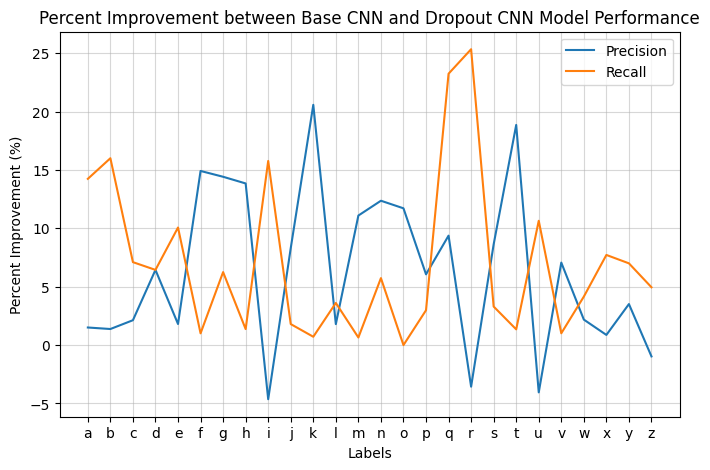

In [198]:
# First we can take the difference between the precision and recall matricies
diff_precision = (prec_CNN_base - prec_CNN_drop)/prec_CNN_base
diff_recall = (rec_CNN_base - rec_CNN_drop)/rec_CNN_base

# Now we can create our line charts
ax = plt
ax.figure(figsize=(8,5))
ax.plot(alphabet, diff_precision*100, label="Precision")
ax.plot(alphabet, diff_recall*100, label="Recall")
ax.xlabel('Labels')
ax.ylabel('Percent Improvement (%)')
ax.legend()
ax.title('Percent Improvement between Base CNN and Dropout CNN Model Performance')
ax.grid(True, alpha=0.5)

Overall the Base CNN Model without Dropout performed better than the one that does include Dropout after each convolutional layer. However, there are some noteable letters that did worse precision wise. These examples are i, q, r, u, and z. These all had a higher recall in the base model, but a worse precision in the base model. What causes this? Typically this would lead us to believe that the model is really good at calling out true positives, and we see this most in the classification of the letter r, but it gets a little over zelous and starts calling other letters r that really aren't. This could mean that the base model is over-generalizing on these letters, and adding in drop out helps mitigate the precision loss. In other cases we attain much higher precision in the Base CNN model, like k and t, where we see performance increases of 17%+. It's possible we're dropping out too early in the model, losing out on some subtleties in these letters like the cross in the t. 

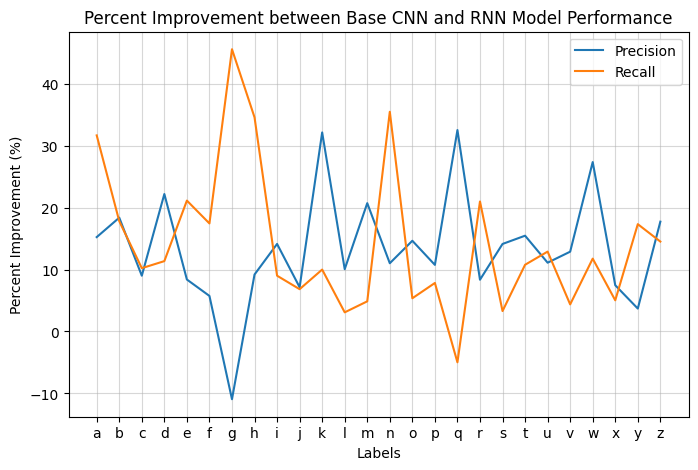

In [199]:
# First we can take the difference between the precision and recall matricies
diff_precision = (prec_CNN_base - prec_RNN)/prec_CNN_base
diff_recall = (rec_CNN_base - rec_RNN)/rec_CNN_base

# Now we can create our line charts
ax = plt
ax.figure(figsize=(8,5))
ax.plot(alphabet, diff_precision*100, label="Precision")
ax.plot(alphabet, diff_recall*100, label="Recall")
ax.xlabel('Labels')
ax.ylabel('Percent Improvement (%)')
ax.legend()
ax.title('Percent Improvement between Base CNN and RNN Model Performance')
ax.grid(True, alpha=0.5)

The comparison between the Base CNN model and LSTM model is a little more all over the place with some letters, but there is a general improvement in the CNN model. As mentioned a few times throughout this report, LSTM really shines in letters that have time-based features, like the curl at the end of g and q. We can see that the LSTM model does around 10% better in precision when it comes to the letter g, most likely picking up better on the curl at the bottom of the letter. However, the Base Model has a much higher recall, almost a 45% improvement over the LSTM model. Again, this means that the Base CNN model is a little too confident that other letters are also g, compared to the LSTM model which tends to be more selective and potentially over-fit. The other notable one is q. We see that the CNN model has better precision, but a little worse Recall. This means for the letter q the CNN Base Model may be over-fit on the q examples it was fed. The LSTM model may benefit by being combined with some form of the CNN model to extract more features. 

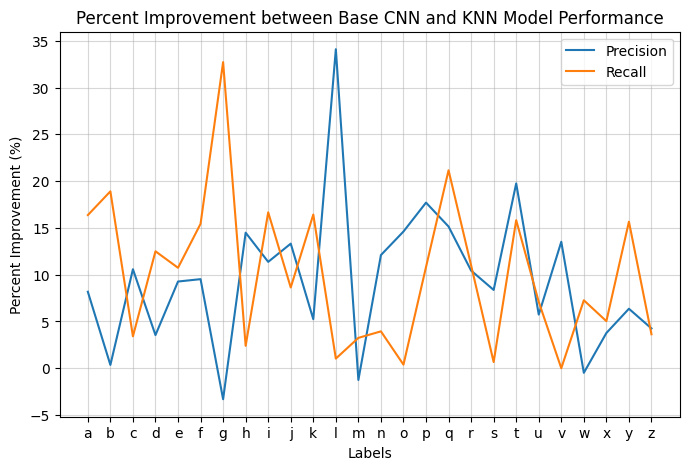

In [200]:
# First we can take the difference between the precision and recall matricies
diff_precision = (prec_CNN_base - prec_KNN)/prec_CNN_base
diff_recall = (rec_CNN_base - rec_KNN)/rec_CNN_base

# Now we can create our line charts
ax = plt
ax.figure(figsize=(8,5))
ax.plot(alphabet, diff_precision*100, label="Precision")
ax.plot(alphabet, diff_recall*100, label="Recall")
ax.xlabel('Labels')
ax.ylabel('Percent Improvement (%)')
ax.legend()
ax.title('Percent Improvement between Base CNN and KNN Model Performance')
ax.grid(True, alpha=0.5)

Lastly, we have the Deep Learning method vs the Supervised Learning method, CNN vs. KNN. As one might expect, Convolutional Neural Networks *should* outperform a KNN model. CNNs are great at learning spatial hieracheries and picking up on variances in handwritten letters, as seen in the almost 35% improvement in precision on the letter l, and general better perfromance across the board. However in some cases KNN actually outperforms the CNN in precision, with g, m and w coming up with minor degredations. KNN actually excels at letters with low variablity, like m and w, which stay pretty consistent over time. For the letter g, I would have expected CNN to improve across the board, which it does in recall, however it seems again it's a little too over-generalized leading to a lower precision. Adding more layers or filters could help here.

Overall, all models performed fairly well given the reduced dataset size (from 88,000 to 40,000) and complexities that come with handwritten letters. We were able to attain test accuracy scores of 92% for our Base CNN model, 86% for our CNN model with Dropout Layers, 78% for our LSTM (RNN) model, and 83% for our KNN model. For the Deep Learning models, we were able to tune the number of epochs we trained for using a custom early stopping method, along with tuning different numbers of layers within the networks, as well as introducing dropout rates. The best model opted for no dropout, and based on our analysis this did lead to some overfitting. For the KNN model, we used a custom hyper-parameter tuning method to optimize for the highest accuracy which resulted in small leaf size and 4 neighbors. We saw some cases where the Deep Learning methods performed worse than the Supervised Learning model, but could potentially be fixed by combining the CNN and RNN methods used in this report.

### **Discussion and Conclusion**

In the end, we achieved our main project goal: To show that we could build basic Deep Learning and Supervised Learning Classifiers on a complex dataset like EMNIST. We were able to successfully clean, explore the data we were working with, train and test Classifier models, and attain moderate performance. While performance isn't at 99%+ levels, like some finely tuned pre-generated models can achieve, our Base Convolutional Neural Net model is able to achieve great results, at 82% accuracy with minimal feature engineering and some hyperparameter tuning. The other models weren't far behind with accuracies of between 86-78%. All of these models took a matter of seconds to train and test, which is optimal for creating high performance letter recognition models on everyday computers.

Moving forward, I think feature engineering up front may make it easier to process and classify the pixel data down the line. Something like normalizing all the pixels to be either black or white, and nothing in between. This would simplify the dataset, and allow for easier feature extraction in these models. As mentioned a couple times, this dataset contains both upper- and lower-case letters. For letters like a (a/A) where the variations aren't all too similar, it introduces complexity that these basic models. I might encourage using something like the EMNIST Balanced dataset that has these broken out into different classes, or make it part of the data cleaning process. Finally, this project did not train and test on the full dataset of 88,000 samples. This increased training could help the classifier reach higher performance metrics, or something like partioning the data using a partioning method would help even more. </br>

I think a lot can be taken from this project, and iterated upon to create high performing classifiers. A use case for something like this could be text-to-speech applications, where on the front end we have a camera taking in images of strings, some pre-processing to break those specific letters into smaller images to be classified. These models could also be paired with other models that could help with predicting the letter that's most likely using other context clues, like how close it is to dictionary words and whatnot. The applications for something like this are endless. 